<a href="https://colab.research.google.com/github/chrishg23-jpg/HES-benchmark/blob/main/RegulatorEvo003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

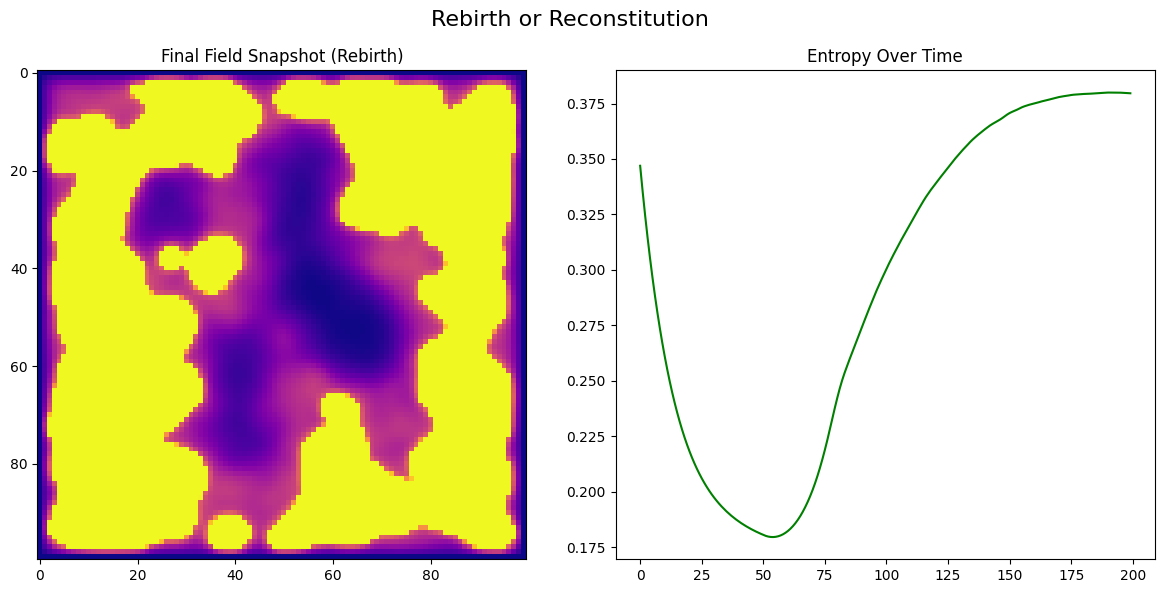

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
GRID_SIZE = 100
TIME_STEPS = 200
SEED_COUNT = 50
NOISE_AMPLITUDE = 0.3
REACTIVATION_START = 50
REACTIVATION_RATE = 0.01

# --- Simulate Collapse to Generate Starting Field ---
collapsed_field = np.zeros((GRID_SIZE, GRID_SIZE))
np.random.seed(42)
for _ in range(SEED_COUNT):
    x, y = np.random.randint(10, 90, size=2)
    collapsed_field[x, y] = 1.0

curvature = np.zeros_like(collapsed_field)
for _ in range(10):
    cx, cy = np.random.randint(20, 80, size=2)
    curvature += np.exp(-((np.indices((GRID_SIZE, GRID_SIZE))[0] - cx)**2 +
                          (np.indices((GRID_SIZE, GRID_SIZE))[1] - cy)**2) / 50)

def collapse_regulator(field, curvature, t):
    suppression = curvature * np.sin(t * 0.1) * NOISE_AMPLITUDE
    regulated_field = field - suppression
    return np.clip(regulated_field, 0, 1)

def collapse_evolve(field):
    new_field = field.copy()
    for i in range(1, GRID_SIZE - 1):
        for j in range(1, GRID_SIZE - 1):
            local_avg = np.mean(field[i-1:i+2, j-1:j+2])
            noise = np.random.normal(0, NOISE_AMPLITUDE)
            new_field[i, j] += (local_avg - field[i, j]) * 0.1 + noise
    return np.clip(new_field, 0, 1)

for t in range(TIME_STEPS):
    collapsed_field = collapse_evolve(collapsed_field)
    collapsed_field = collapse_regulator(collapsed_field, curvature, t)

# --- Begin Rebirth Simulation ---
field = collapsed_field.copy()
entropy_log = []
frames = []

def rebirth_regulator(field, t):
    strength = max(0, (t - REACTIVATION_START) * REACTIVATION_RATE)
    entropy = np.std(field)
    memory_zone = field > 0.6
    feedback = strength * memory_zone.astype(float) * 0.1
    regulated_field = field + feedback
    return np.clip(regulated_field, 0, 1), entropy

def rebirth_evolve(field):
    new_field = field.copy()
    for i in range(1, GRID_SIZE - 1):
        for j in range(1, GRID_SIZE - 1):
            local_avg = np.mean(field[i-1:i+2, j-1:j+2])
            new_field[i, j] += (local_avg - field[i, j]) * 0.05
    return np.clip(new_field, 0, 1)

for t in range(TIME_STEPS):
    field = rebirth_evolve(field)
    field, entropy = rebirth_regulator(field, t)
    entropy_log.append(entropy)
    if t % 20 == 0:
        frames.append(field.copy())

# --- Visualization ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(frames[-1], cmap='plasma')
axs[0].set_title("Final Field Snapshot (Rebirth)")

axs[1].plot(entropy_log, color='green')
axs[1].set_title("Entropy Over Time")

plt.suptitle("Rebirth or Reconstitution", fontsize=16)
plt.tight_layout()
plt.show()
